In [1]:
import matplotlib.pyplot as plt
plt.style.use('../note.mplstyle')
import numpy as np

In [2]:
from qutip import *

# Hamiltonian

$$
H_{lab} = \sum_{j=0}^{1}{\hbar\omega_{j}\frac{\sigma_{j}^{z}}{2}} 
- J_{01}\sigma_{0}^{z}\sigma_{1}^{z}
+ \sum_{j=0}^{1}{\hbar\Omega_{j}\cos{(\omega_{MW,j}t)}\sigma_{j}^{x}}
$$

$$
H_{rot}^{RWA} 
= \sum_{j=0}^{1}{\hbar(\omega_{j}-\omega_{MW,j})\frac{\sigma_{j}^{z}}{2}} 
- J_{01}\sigma_{0}^{z}\sigma_{1}^{z}
+ \sum_{j=0}^{1}{\hbar\Omega_{j}\frac{\sigma_{j}^{x}}{2}}
$$

In [3]:
del0 = 0.
del1 = 0.

w0 = 10 * 2 * np.pi # qubit frequency
w1 = 10 * 2 * np.pi

wR0 = 0.3 * 2 * np.pi  # Rabi amplitude
wR1 = 0.3 * 2 * np.pi  # Rabi amplitude

J01 = 0.

wmw0 = w0 - del0 # w0
wmw1 = w1 - del1 # w1

w = np.array([w0, w1])
wR = np.array([wR0, wR1])
wmw = np.array([wmw0, wmw1])
assert w.size == wR.size and w.size == wmw.size
N = w.size

In [4]:
zero = Qobj(np.zeros((2,2)))

I, sigx, sigy, sigz = identity(2), sigmax(), sigmay(), sigmaz()

In [5]:
sigz_0 = tensor([sigz,I])
sigz_1 = tensor([I,sigz])
sigzlist = [sigz_0, sigz_1]

sigx_0 = tensor([sigx,I])
sigx_1 = tensor([I,sigx])
sigxlist = [sigx_0, sigx_1]

sigzsigz = tensor(sigz,sigz)

In [6]:
sigzlist[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

In [7]:
sigxlist[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

In [8]:
# (w[j]-wmw[j]) * (sigzlist[j]/2.) + wR[j] * (sigxlist[j]/2.)

# np.zeros((4,4))

# sigzlist[0]

# tensor([zero,zero])

In [22]:
options = Options(nsteps=20000)

H0 = tensor([zero,zero])
for j in range(N):
    H0 += (w[j]-wmw[j]) * (sigzlist[j]/2.) # + wR[j] * (sigxlist[j]/2.)

Hdrive = tensor([zero,zero])
for j in range(N):
    Hdrive += wR[j] * (sigxlist[j]/2.)

H0 = (- J01) * sigzsigz
# H += (- J01) * sigzsigz
H = H0 + Hdrive

In [24]:
H0.eigenenergies()

array([0., 0., 0., 0.])

In [25]:
T_pi = np.pi / (wR[0])

tmax = T_pi # 10
t = np.linspace(0,tmax,201)

In [26]:
sigvec = [sigx,sigy,sigz]

c_ops = []

In [27]:
rho_00_00 = ket2dm(tensor([basis(2,0),basis(2,0)]))

# rho_00_00

# fidelity(rho_00_00, rho_00_00)

# rho_t0 = rho_00_00

def fidel_00_00(t, rho):
#     _rho_00_00 = ket2dm(tensor([basis(2,0),basis(2,0)]))
    return fidelity(rho_00_00, rho)

# fidel_00_00(_, rho_00_00)

res_00_00 = mesolve(H, rho_00_00, t, c_ops, fidel_00_00, options=options)

assert not np.any(np.abs(np.imag(res_00_00.expect)).max() > 1e-15)
fidel_00_00_from_00_00 = np.real(res_00_00.expect)

In [28]:
rho_01_01 = ket2dm(tensor([basis(2,0),basis(2,1)]))

# rho_t0 = rho_01_01

rho_11_11 = ket2dm(tensor([basis(2,1),basis(2,1)]))
def fidel_11_11(t, rho):
#     rho_11_11 = ket2dm(tensor([basis(2,1),basis(2,1)]))
    global rho_11_11
    return fidelity(rho_11_11, rho)

res_01_01 = mesolve(H, rho_01_01, t, c_ops, fidel_11_11, options=options)

assert not np.any(np.abs(np.imag(res_01_01.expect)).max() > 1e-15)
fidel_11_11_from_01_01 = np.real(res_01_01.expect)

# [TODO] Compare the `fidelity()` function in `qutip` and the analytical calculation for some density operators

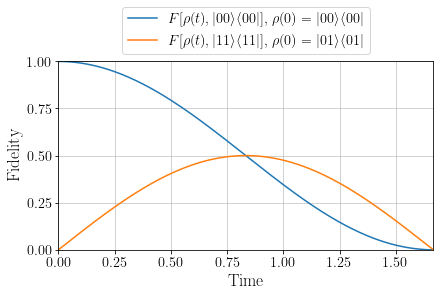

In [29]:
fig, ax = plt.subplots(constrained_layout=True)

l_00_from_00, = ax.plot(t, fidel_00_00_from_00_00)
l_11_from_01, = ax.plot(t, fidel_11_11_from_01_01)
ax.set_xlim(t[[0,-1]])
ax.set_ylim(0,1)
ax.set_xlabel(r"Time")
ax.set_ylabel("Fidelity")
ax.legend(
    [l_00_from_00, l_11_from_01], 
    [r"$F[\rho(t), |00\rangle\langle 00|]$, $\rho(0)=|00\rangle\langle 00|$", 
     r"$F[\rho(t), |11\rangle\langle 11|]$, $\rho(0)=|01\rangle\langle 01|$"],
    loc='lower center',
    bbox_to_anchor=(0.5,1)
)
ax.yaxis.set_ticks([0,0.25,0.5,0.75,1])
ax.grid(True, alpha=0.75, lw=0.75)
ax.set_axisbelow(True)
# fig.savefig("fidelities-test-003.png")